# Prudential Life Insurance Assessment

## Part 3 - H2O AutoML with MLflow

### Contents
[Part 1 - Initial Setup](#setup)  
[Part 2 - H2O AutoML Training with MLflow Tracking](#automl)  
[Part 3 - Predict with H2O AutoML Best Model](#predict)  
[Part 4 - H2O Model Explainability](#explain)  
[Part 5 - References](#references)

___
<a name="setup"></a>
## (1) Initial Setup

### Install pre-requisite dependencies

In [1]:
# !pip install requests
# !pip install tabulate
# !pip install future

### Install H2O in Python

In [2]:
# !pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

### Install MLflow

In [3]:
# !pip install mlflow

### Import dependencies and datasets

In [4]:
# Import libraries
import h2o
from h2o.automl import H2OAutoML, get_leaderboard

import mlflow
import mlflow.h2o
from mlflow.tracking import MlflowClient
from mlflow.entities import ViewType

import json

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Initiate H2O cluster

In [5]:
# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.281-b09, mixed mode)
  Starting server from C:\ProgramData\Anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\kenne\AppData\Local\Temp\tmpr1gpbhb6
  JVM stdout: C:\Users\kenne\AppData\Local\Temp\tmpr1gpbhb6\h2o_kenne_started_from_python.out
  JVM stderr: C:\Users\kenne\AppData\Local\Temp\tmpr1gpbhb6\h2o_kenne_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,05 secs
H2O_cluster_timezone:,Asia/Singapore
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.34.0.3
H2O_cluster_version_age:,1 month and 16 days
H2O_cluster_name:,H2O_from_python_kenne_9scs79
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.768 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


### Setup MLflow

- First open Powershell terminal and change path to the directory hosting this notebook (e.g. `cd D:\AutoML-Project\`
- Enter `mlflow ui` to initiate MLFlow server
- Once done, access the MLFlow UI served on http://127.0.0.1:5000

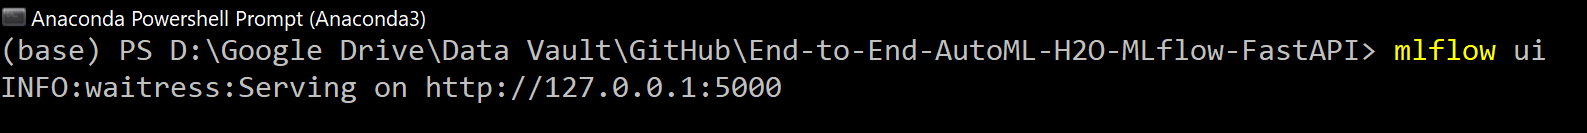

In [6]:
# Initialize MLFlow client
client = MlflowClient()

# Set up MlFlow experiment
experiment_name = 'insurance-automl'

try:
    experiment_id = mlflow.create_experiment(experiment_name)
    experiment = client.get_experiment_by_name(experiment_name)
except:
    experiment = client.get_experiment_by_name(experiment_name)
    
mlflow.set_experiment(experiment_name)

# Print experiment details
print(f"Name: {experiment_name}")
print(f"Experiment_id: {experiment.experiment_id}")
print(f"Artifact Location: {experiment.artifact_location}")
print(f"Tags: {experiment.tags}")
print(f"Lifecycle_stage: {experiment.lifecycle_stage}")
print(f"Tracking uri: {mlflow.get_tracking_uri()}")

Name: insurance-automl
Experiment_id: 3
Artifact Location: file:///D:/Google%20Drive/Data%20Vault/GitHub/AutoML-Insurance-H2O-MLflow-FastAPI/mlruns/3
Tags: {}
Lifecycle_stage: active
Tracking uri: file:///D:/Google%20Drive/Data%20Vault/GitHub/AutoML-Insurance-H2O-MLflow-FastAPI/mlruns


___
<a name="automl"></a>
## (2) H2O AutoML Training with MLFlow Tracking

### Import training data
- Not splitting further into train/val set because 5-fold cross-val is applied by default in the AutoML training

In [7]:
# Import data directly as H2O frame
main_frame = h2o.import_file(path='data/processed/train.csv')

# Save data types of columns in H2O frame (for matching with test set during prediction)
with open('data/processed/train_col_types.json', 'w') as fp:
    json.dump(main_frame.types, fp)

# # Alternatively, can first import as pandas csv, then convert to H2O frame
# main_df = pd.read_csv('data/processed/train.csv')
# main_frame = h2o.H2OFrame(main_df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [8]:
# Set predictor and target columns
target = 'Response'
predictors = [n for n in main_frame.col_names if n != target]

# Factorize target variable so that autoML tackles classification problem (instead of regression)
main_frame[target] = main_frame[target].asfactor()

# Visualize H2O frame structure
main_frame.head()

Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_4,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,Medical_History_11,Medical_History_12,Medical_History_13,Medical_History_14,Medical_History_16,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Medical_Keyword_1,Medical_Keyword_2,Medical_Keyword_3,Medical_Keyword_4,Medical_Keyword_5,Medical_Keyword_6,Medical_Keyword_7,Medical_Keyword_8,Medical_Keyword_9,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response,Product_Info_2_Alpha,Product_Info_2_Num,Med_Keywords_Count
1,16,10,0.0769231,2,1,1,0.641791,0.581818,0.148536,0.323008,0.028,12,1,0,3,nan,1,2,6,3,1,2,1,1,1,3,1,0.000666667,1,1,2,2,nan,nan,4,112,2,1,1,3,2,2,1,3,2,3,3,3,3,1,1,2,1,2,3,1,3,3,1,3,2,3,1,3,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,3,0
1,0,26,0.0769231,2,3,1,0.0597015,0.6,0.131799,0.272288,0,1,3,0,2,0.0018,1,2,6,3,1,2,1,2,1,3,1,0.000133333,1,3,2,2,0.188406,0.084507,5,412,2,1,1,3,2,2,1,3,2,3,3,1,3,1,1,2,1,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0
1,18,26,0.0769231,2,3,1,0.0298507,0.745455,0.288703,0.42878,0.03,9,1,0,2,0.03,1,2,8,3,1,1,1,2,1,1,3,nan,3,2,3,3,0.304348,0.225352,10,3,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,4,1,0
1,17,10,0.487179,2,3,1,0.164179,0.672727,0.205021,0.352438,0.042,9,1,0,3,0.2,2,2,8,3,1,2,1,2,1,1,3,nan,3,2,3,3,0.42029,0.352113,0,350,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,2,2,3,1,3,3,1,3,2,3,3,3,1,2,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,4,1
1,15,26,0.230769,2,3,1,0.41791,0.654545,0.23431,0.424046,0.027,9,1,0,2,0.05,1,2,6,3,1,2,1,2,1,1,3,nan,3,2,3,2,0.463768,0.408451,nan,162,2,2,1,3,2,2,2,3,2,3,3,1,3,1,1,2,1,2,3,2,2,3,1,3,2,3,3,3,1,3,2,1,3,3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,3,2,0
1,15,26,0.230769,3,1,1,0.507463,0.836364,0.299163,0.364887,0.325,15,1,0,2,1,1,2,8,3,1,1,1,2,1,3,2,0.005,1,3,2,2,nan,0.507042,6,491,2,2,1,3,2,2,2,3,2,3,3,1,3,2,1,2,2,2,3,1,3,3,1,3,2,3,3,1,1,2,2,1,3,3,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0

### Start H2O AutoML training with MLflow tracking

In [9]:
# Wrap autoML training with MLflow
with mlflow.start_run():
    aml = H2OAutoML(
                    max_models=15, # Run AutoML for n base models
                    seed=42, 
                    balance_classes=True, # Our target classes are imbalanced, so we set this to True
                    sort_metric='logloss', # Sort models by logloss (main metric for multi-classification)
                    verbosity='info', # Turn on verbose info
                    exclude_algos = ['GLM', 'DRF'], # Specify which algorithms to exclude
                   )
    
    aml.train(x=predictors, y=target, training_frame=main_frame)
    
    # Set metrics to log
    mlflow.log_metric("log_loss", aml.leader.logloss())
    mlflow.log_metric("mean_per_class_error", aml.leader.mean_per_class_error())
    
    # Log best model (mlflow.h2o module provides API for logging & loading H2O models)
    mlflow.h2o.log_model(aml.leader, 
                         artifact_path="model",
#                          registered_model_name='automl-insurance'
                        )
    
    model_uri = mlflow.get_artifact_uri("model")
    print(model_uri)
    
    # Print and view AutoML Leaderboard
    lb = get_leaderboard(aml, extra_columns='ALL')
    print(lb.head(rows=lb.nrows))
    
    # Get IDs of current experiment run
    exp_id = experiment.experiment_id
    run_id = mlflow.active_run().info.run_id
    
    # Save leaderboard as CSV
    lb_path = f'mlruns/{exp_id}/{run_id}/artifacts/model/leaderboard.csv'
    lb.as_data_frame().to_csv(lb_path, index=False) 
    print(f'Leaderboard saved in {lb_path}')

AutoML progress: |
20:40:50.676: Project: AutoML_1_20211114_204050
20:40:50.676: Setting stopping tolerance adaptively based on the training frame: 0.004103706068429825
20:40:50.676: Build control seed: 42
20:40:50.692: training frame: Frame key: AutoML_1_20211114_204050_training_py_1_sid_831c    cols: 124    rows: 59381  chunks: 32    size: 6962307  checksum: -5815434094247804574
20:40:50.692: validation frame: NULL
20:40:50.692: leaderboard frame: NULL
20:40:50.692: blending frame: NULL
20:40:50.692: response column: Response
20:40:50.692: fold column: null
20:40:50.692: weights column: null
20:40:50.692: AutoML: XGBoost is not available; skipping it.
20:40:50.692: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (

model_id,logloss,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
StackedEnsemble_AllModels_6_AutoML_1_20211114_204050,1.23589,0.607264,0.648894,0.421064,2.25954e+06,0.19745,StackedEnsemble
StackedEnsemble_AllModels_4_AutoML_1_20211114_204050,1.2374,0.608125,0.650364,0.422973,244491,0.195394,StackedEnsemble
StackedEnsemble_AllModels_3_AutoML_1_20211114_204050,1.23869,0.607192,0.650689,0.423397,160813,0.179172,StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20211114_204050,1.24017,0.606993,0.650757,0.423484,97201,0.127545,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20211114_204050,1.24328,0.608298,0.651351,0.424258,65905,0.095858,StackedEnsemble
StackedEnsemble_AllModels_5_AutoML_1_20211114_204050,1.24496,0.613462,0.649945,0.422428,201670,0.216975,StackedEnsemble
StackedEnsemble_BestOfFamily_4_AutoML_1_20211114_204050,1.24971,0.611719,0.653497,0.427059,603275,0.034314,StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20211114_204050,1.25036,0.612365,0.654178,0.427948,73529,0.034868,StackedEnsemble
StackedEnsemble_BestOfFamily_1_AutoML_1_20211114_204050,1.25152,0.612915,0.65453,0.428409,50988,0.027612,StackedEnsemble
StackedEnsemble_BestOfFamily_3_AutoML_1_20211114_204050,1.25392,0.618945,0.653108,0.42655,37809,0.047322,StackedEnsemble



Leaderboard saved in mlruns/3/fa6d2a1014f74dd3a4b240a8ae03b5aa/artifacts/model/leaderboard.csv


### View AutoML logs

In [10]:
# Get AutoML event log
log = aml.event_log
log

timestamp,level,stage,message,name,value
20:40:50.676,Info,Workflow,Project: AutoML_1_20211114_204050,,
20:40:50.676,Info,Validation,Setting stopping tolerance adaptively based on the training frame: 0.004103706068429825,,
20:40:50.676,Info,Validation,Build control seed: 42,,
20:40:50.692,Info,DataImport,training frame: Frame key: AutoML_1_20211114_204050_training_py_1_sid_831c cols: 124 rows: 59381 chunks: 32 size: 6962307 checksum: -5815434094247804574,,
20:40:50.692,Info,DataImport,validation frame: NULL,,
20:40:50.692,Info,DataImport,leaderboard frame: NULL,,
20:40:50.692,Info,DataImport,blending frame: NULL,,
20:40:50.692,Info,DataImport,response column: Response,,
20:40:50.692,Info,DataImport,fold column: null,,
20:40:50.692,Info,DataImport,weights column: null,,


### View best model

In [11]:
# Leader (best) model stored here
aml.leader

Model Details
H2OStackedEnsembleEstimator :  Stacked Ensemble
Model Key:  StackedEnsemble_AllModels_6_AutoML_1_20211114_204050

No model summary for this model

ModelMetricsMultinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.3165092977464875
RMSE: 0.5625915905401426

ModelMetricsMultinomialGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.42106372086617494
RMSE: 0.6488942293364728


#### Learning Curve Plot

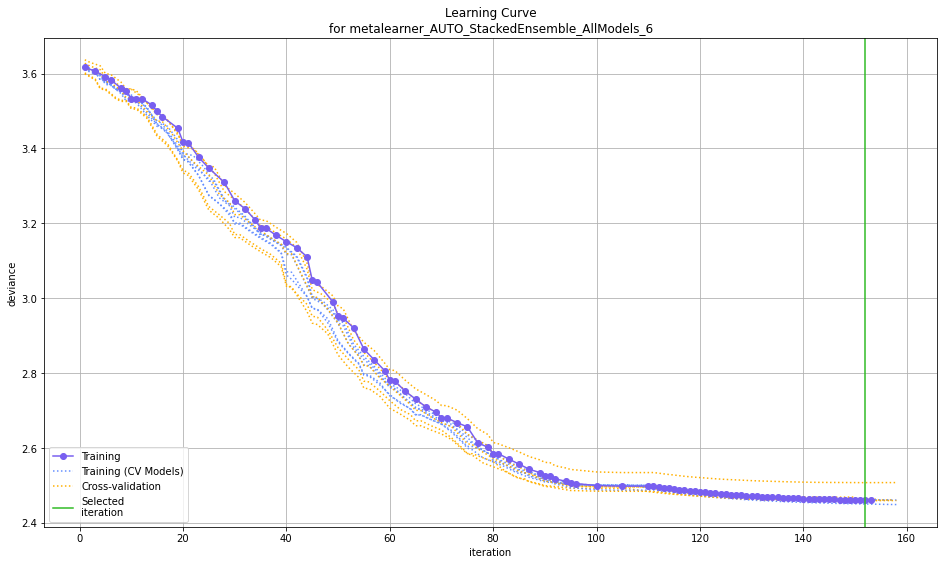

In [12]:
# Display learning curve
learning_curve_plot = aml.leader.learning_curve_plot()

___
<a name="predict"></a>
## (3) Predict with H2O AutoML Best Model

### Prepare test data

In [ ]:
# Import test data
test_frame = h2o.import_file(path='data/processed/test.csv')

# Store ID list of test set
X_id = test_frame[:, 'Id']

# Drop ID column for test set
X_test_frame = test_frame.drop('Id')

### Load leader model from MLflow saved in artifacts

In [14]:
# Get dataframe of all runs
all_experiments = [exp.experiment_id for exp in client.list_experiments()]
runs = mlflow.search_runs(experiment_ids=all_experiments, run_view_type=ViewType.ALL)

# Identify best model (experiment id and run id) amongst all runs in the experiment
run_id, exp_id = runs.loc[runs['metrics.log_loss'].idxmin()]['run_id'], runs.loc[runs['metrics.log_loss'].idxmin()]['experiment_id']
run_id, exp_id

('3832390d98be4b30bc441aa6b7675357', '1')

In [15]:
# Load best model (AutoML leader)
best_model = mlflow.h2o.load_model(f"mlruns/{exp_id}/{run_id}/artifacts/model/")

# Generate predictions with best model (output is H2O frame)
preds = best_model.predict(X_test_frame)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


### Get Kaggle Submission Score

In [16]:
# Convert to submission format (first convert H2O frames to pandas)
submission = pd.DataFrame({'Id': X_id.as_data_frame()['Id'].values, 
                           'Response': preds.as_data_frame()['predict'].values})
submission.head()

,Id,Response
0,1,1
1,3,8
2,4,6
3,9,8
4,12,8


In [17]:
# Save as CSV for submission online on Kaggle
submission.to_csv(f'submissions/prudential_{run_id}.csv', index=False)

##### Final Score: 0.56671
- Accuracy score is much higher than expected (random guess) score of 0.125 (since there are 8 labels)
- Score is slightly better than 0.56279 from XGBoost baseline model (see `02_XGBoost_Baseline_Model.ipynb`)
- Nonetheless, this score is still a fair amount away from the top Kaggle competition of 0.67938 
- This means that more focus and effort should be spent on the feature engineering/selection, rather than the modelling

___
<a name="explain"></a>
## (4) H2O Model Explainability
- More info: https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_AllModels_6_AutoML_1_20211108_10509


Confusion Matrix: Row labels: Actual class; Column labels: Predicted class


,1,2,3,4,5,6,7,8,Error,Rate
0,611.0,7.0,1.0,5.0,25.0,97.0,43.0,155.0,0.352754,333 / 944
1,5.0,624.0,3.0,6.0,40.0,109.0,55.0,114.0,0.347280,332 / 956
2,1.0,7.0,93.0,8.0,7.0,24.0,7.0,4.0,0.384106,58 / 151
3,6.0,1.0,1.0,89.0,0.0,79.0,7.0,38.0,0.597285,132 / 221
4,17.0,21.0,4.0,1.0,594.0,93.0,42.0,67.0,0.292014,245 / 839
5,25.0,21.0,0.0,11.0,18.0,1189.0,121.0,289.0,0.289725,"485 / 1,674"
6,7.0,13.0,1.0,14.0,3.0,96.0,742.0,363.0,0.401130,"497 / 1,239"
7,7.0,8.0,0.0,10.0,7.0,81.0,56.0,2840.0,0.056165,"169 / 3,009"
8,679.0,702.0,103.0,144.0,694.0,1768.0,1073.0,3870.0,0.249197,"2,251 / 9,033"


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

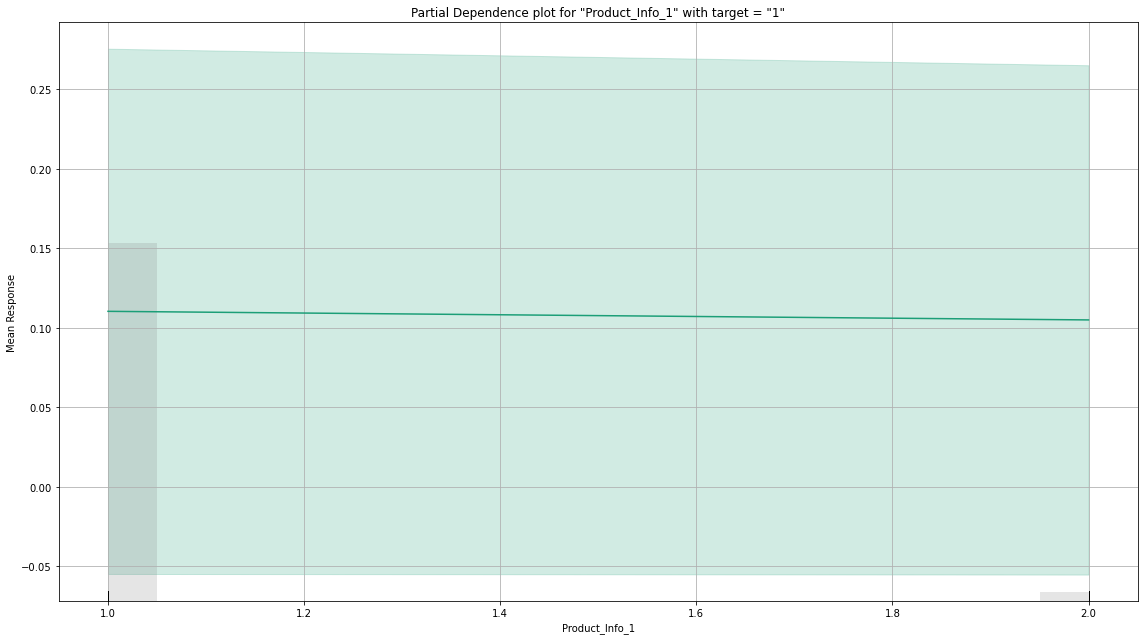

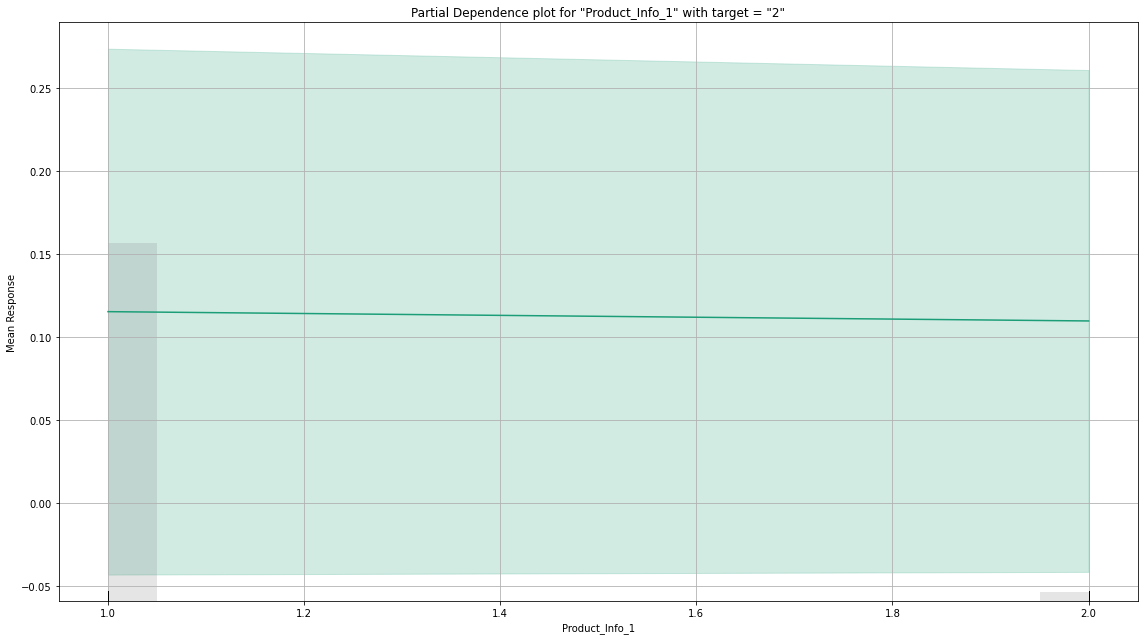

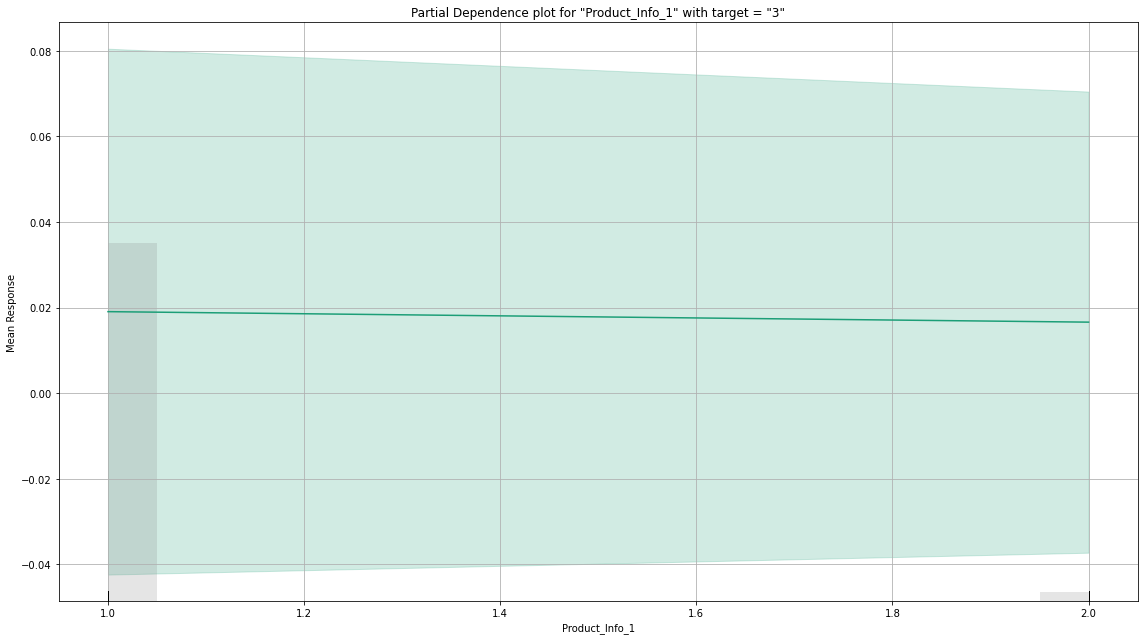

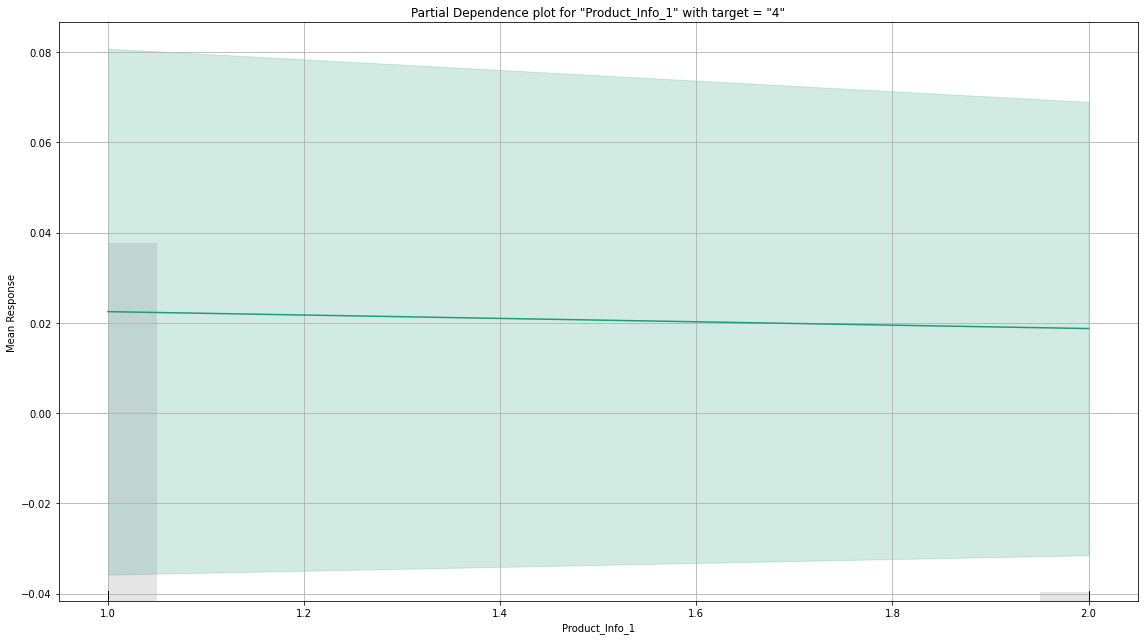

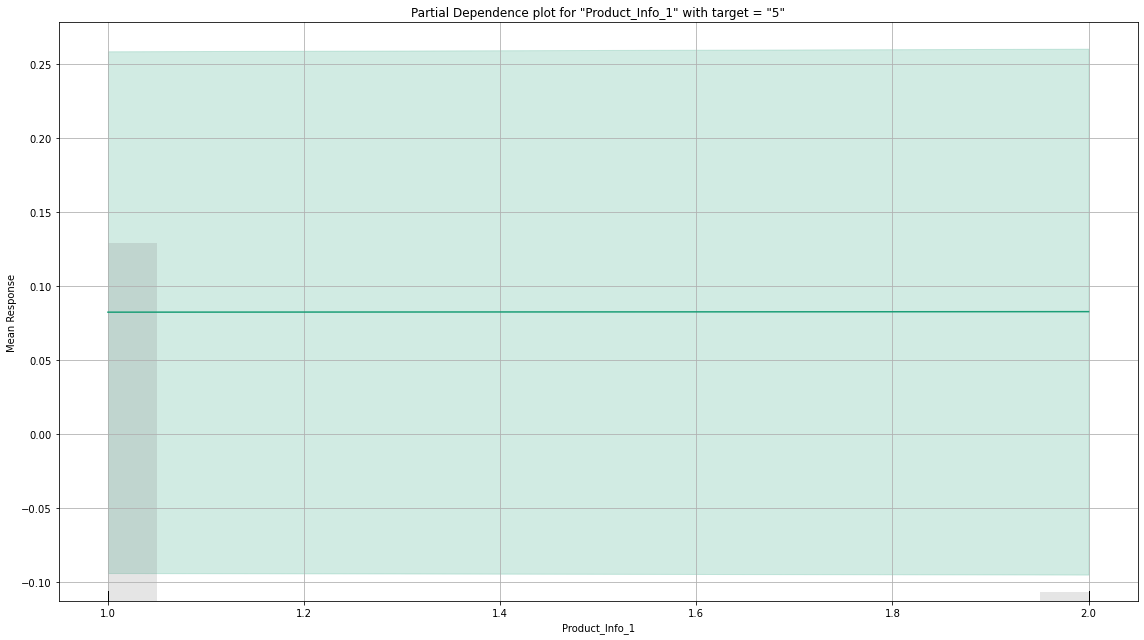

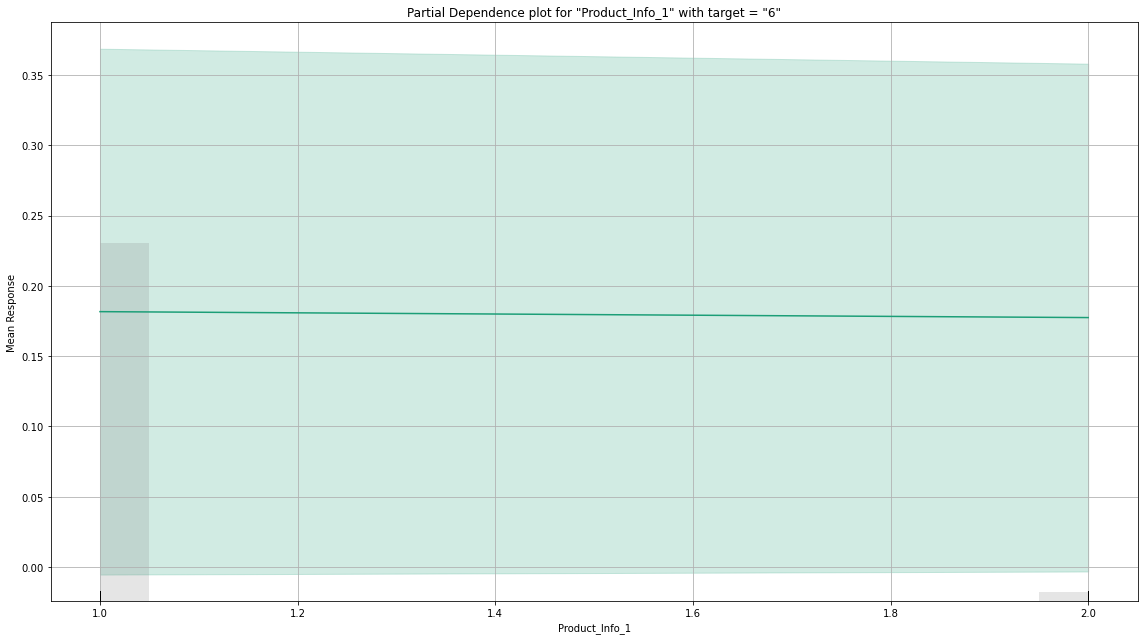

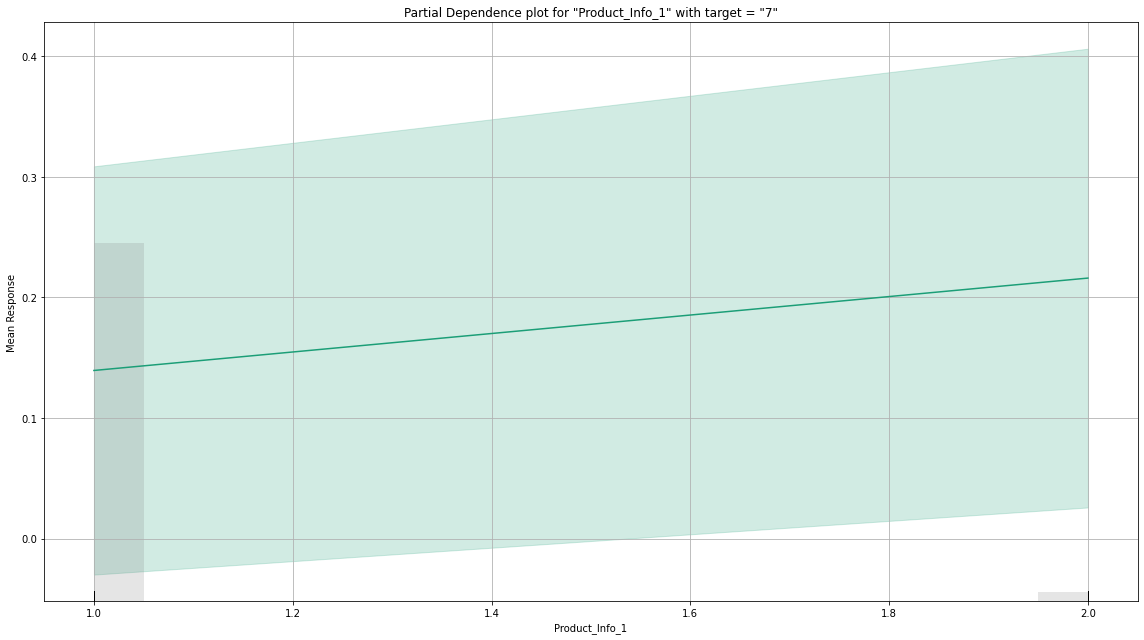

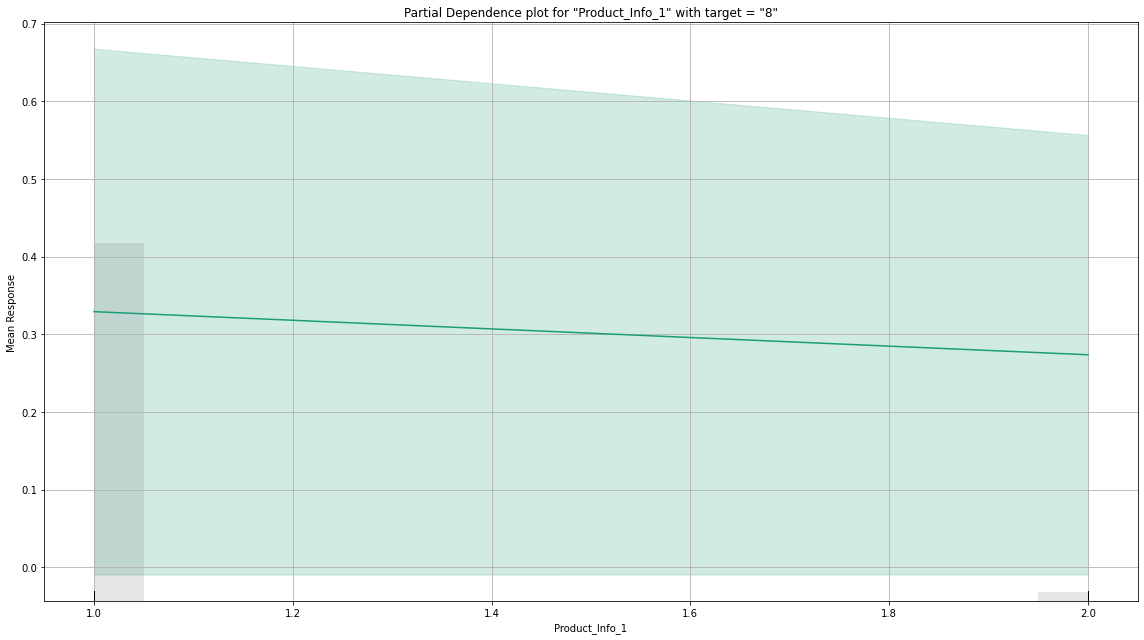

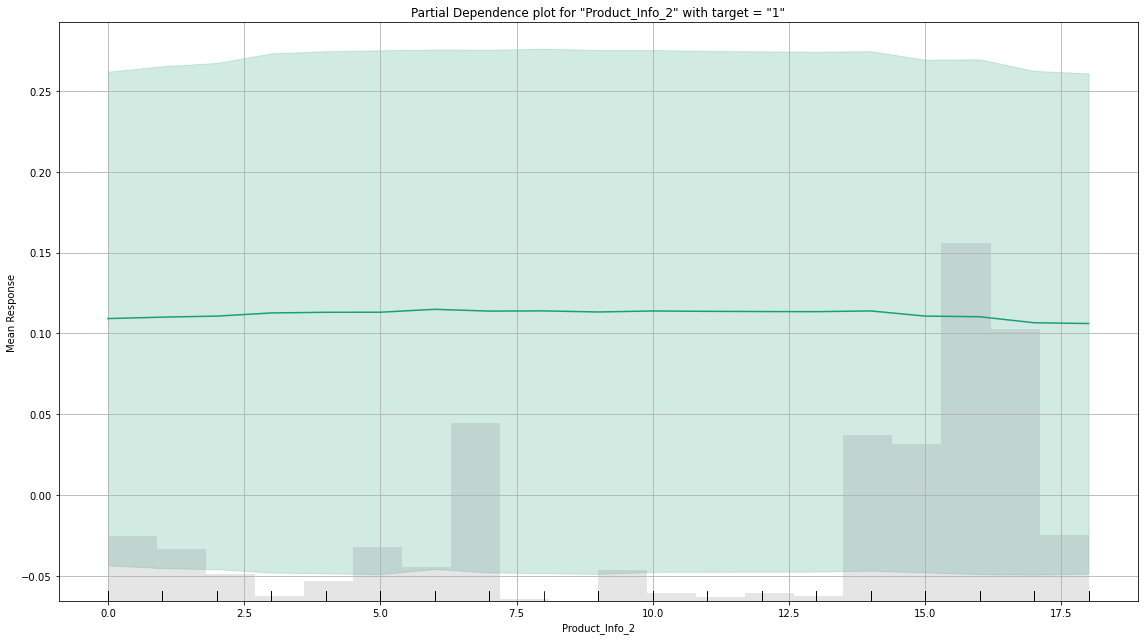

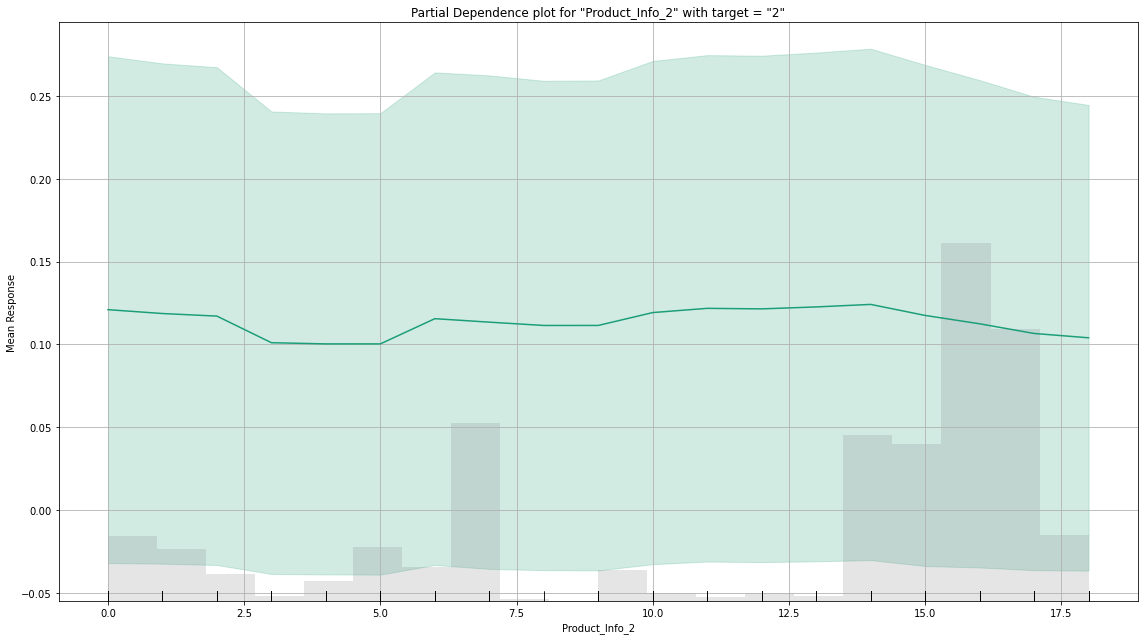

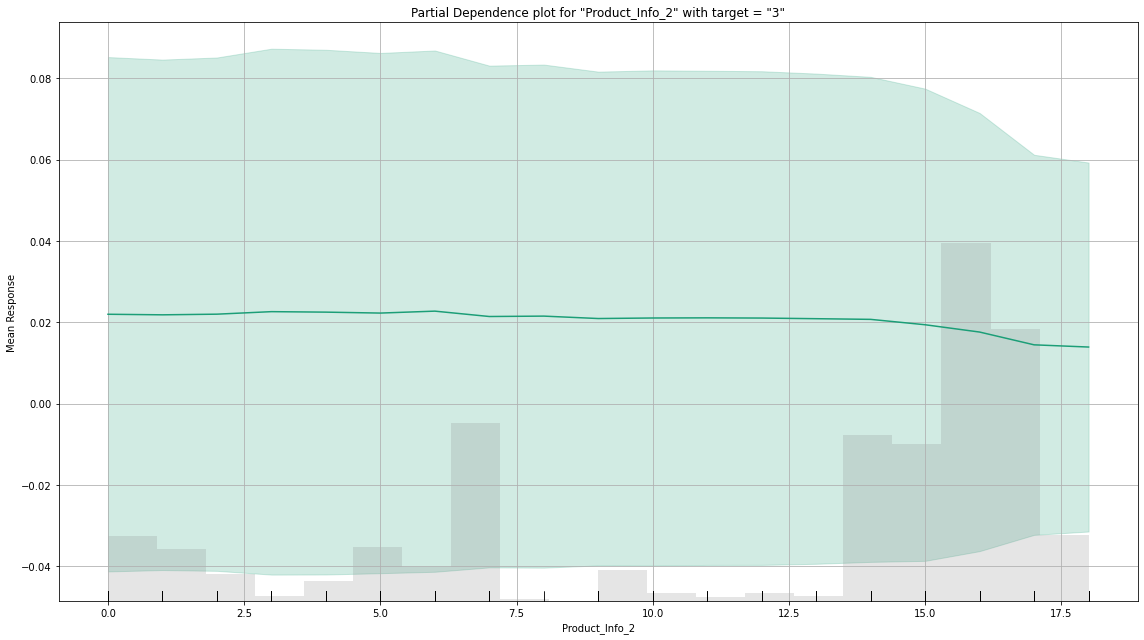

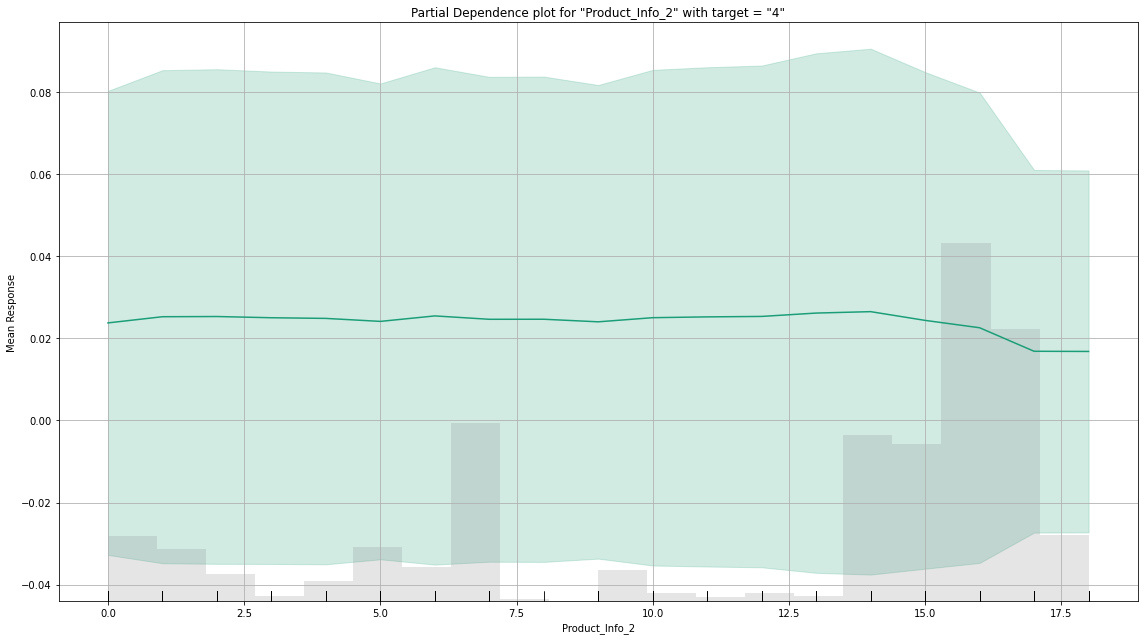

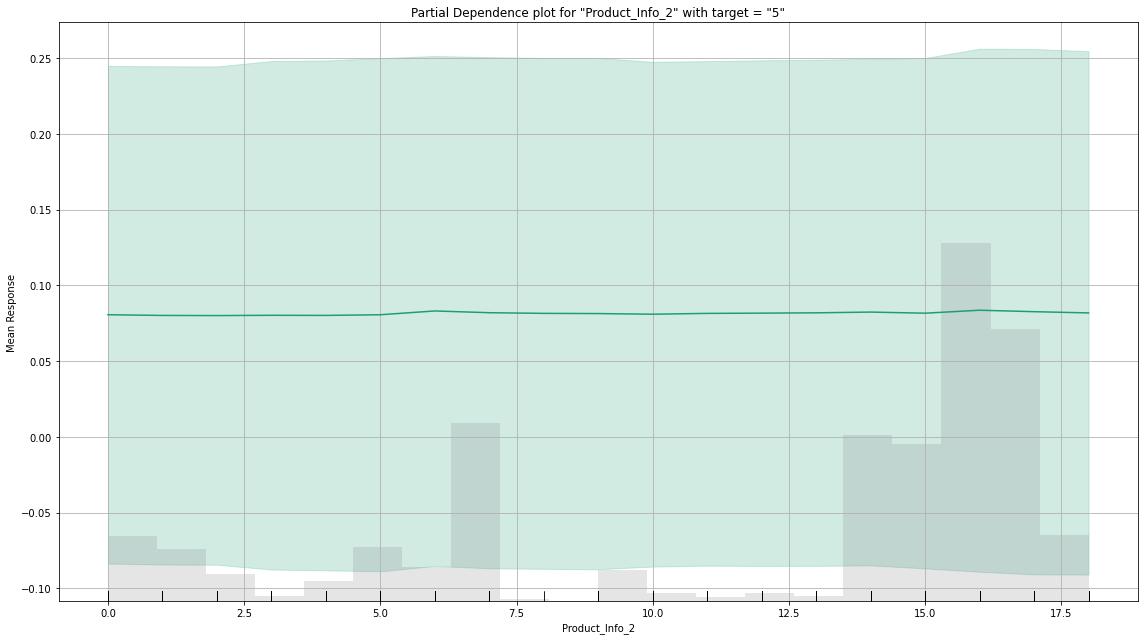

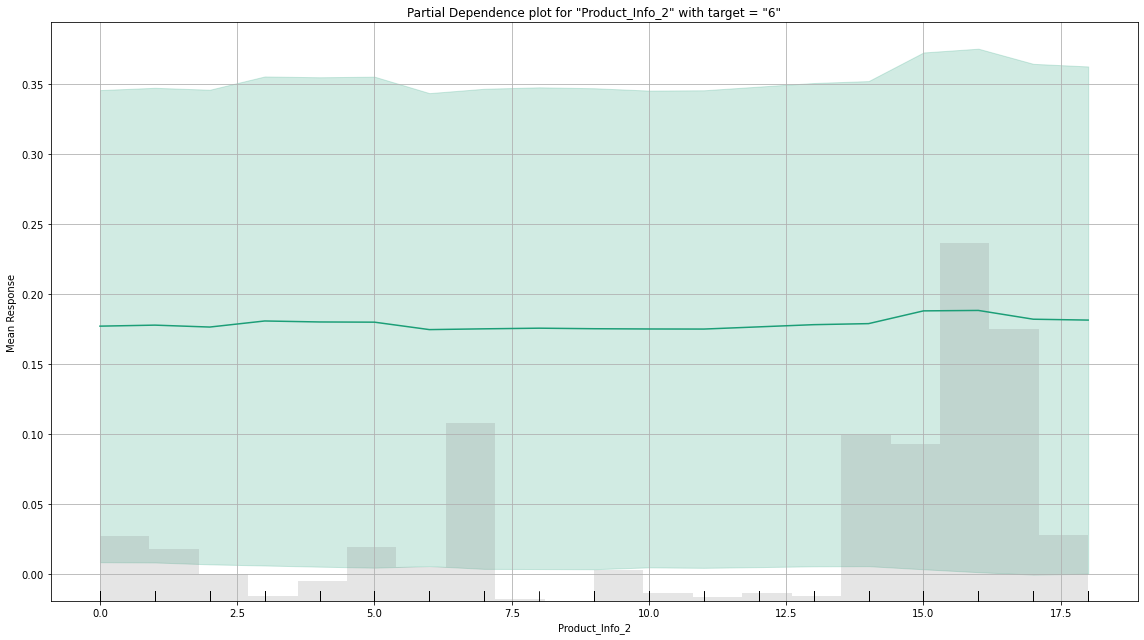

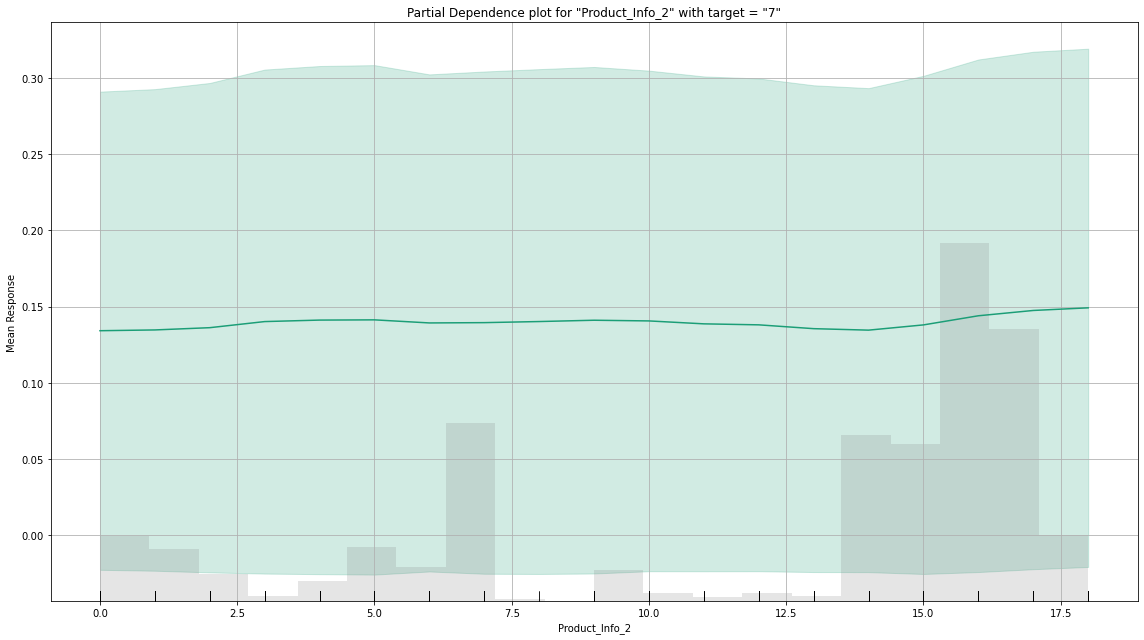

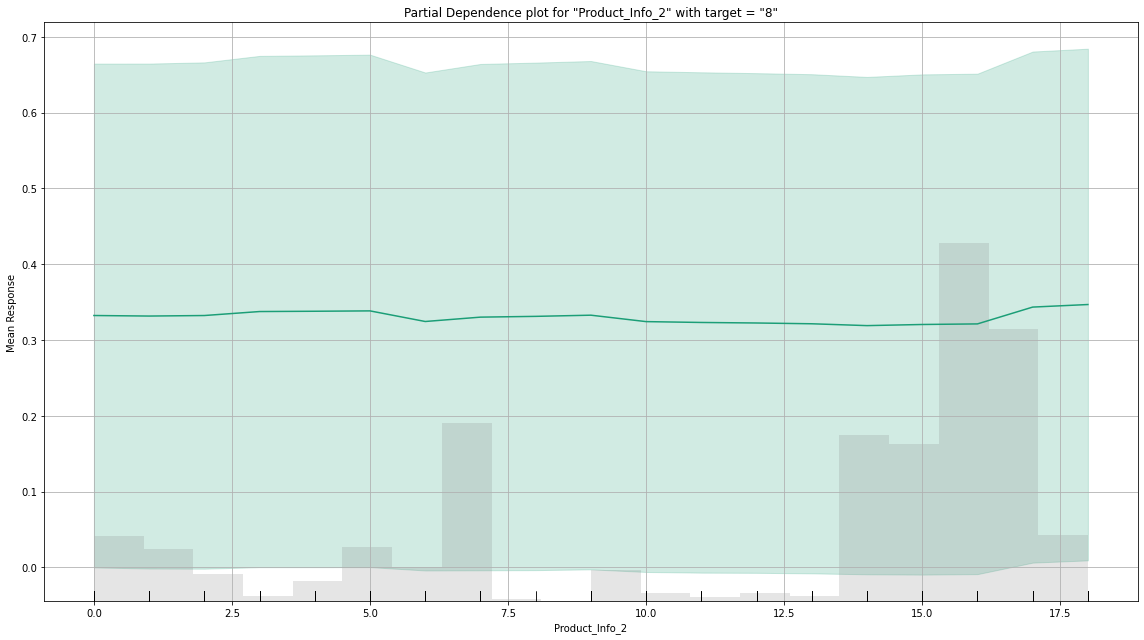

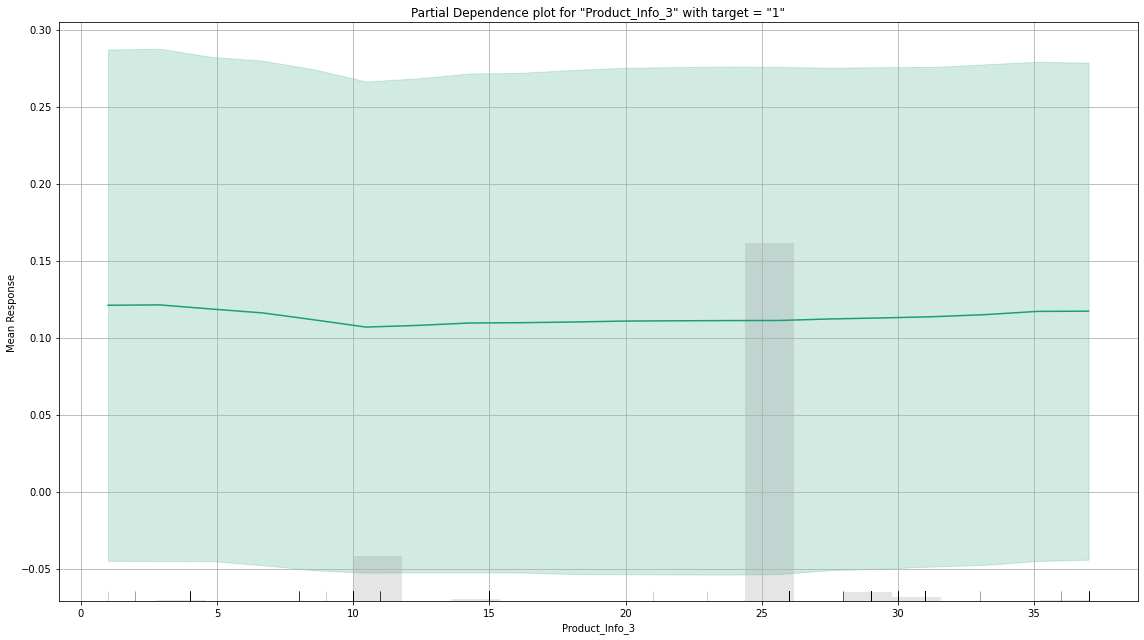

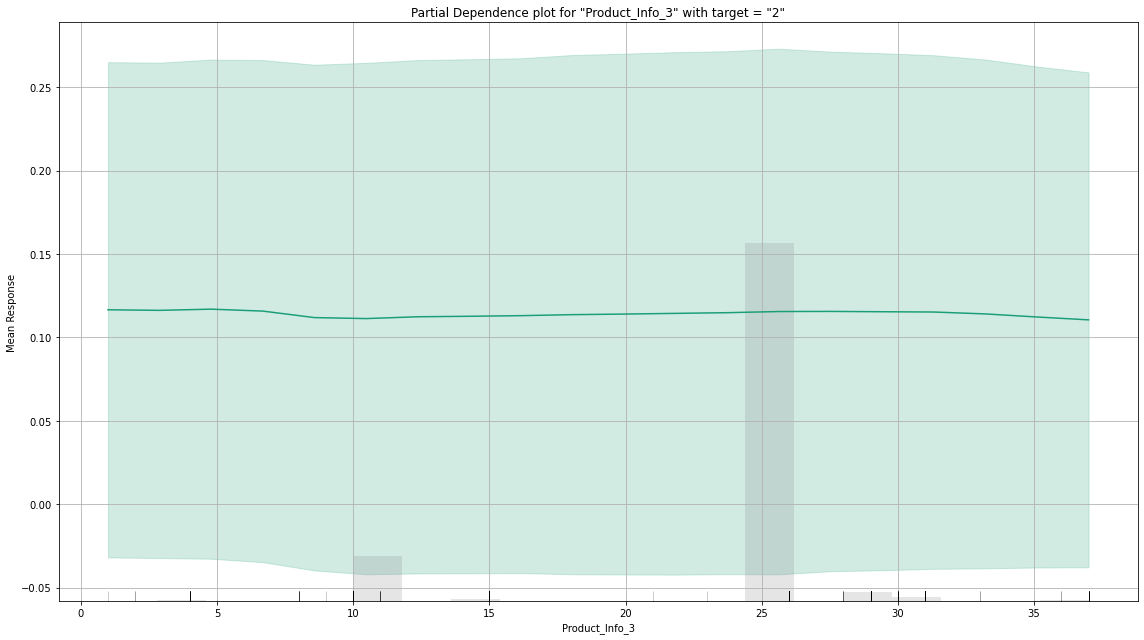

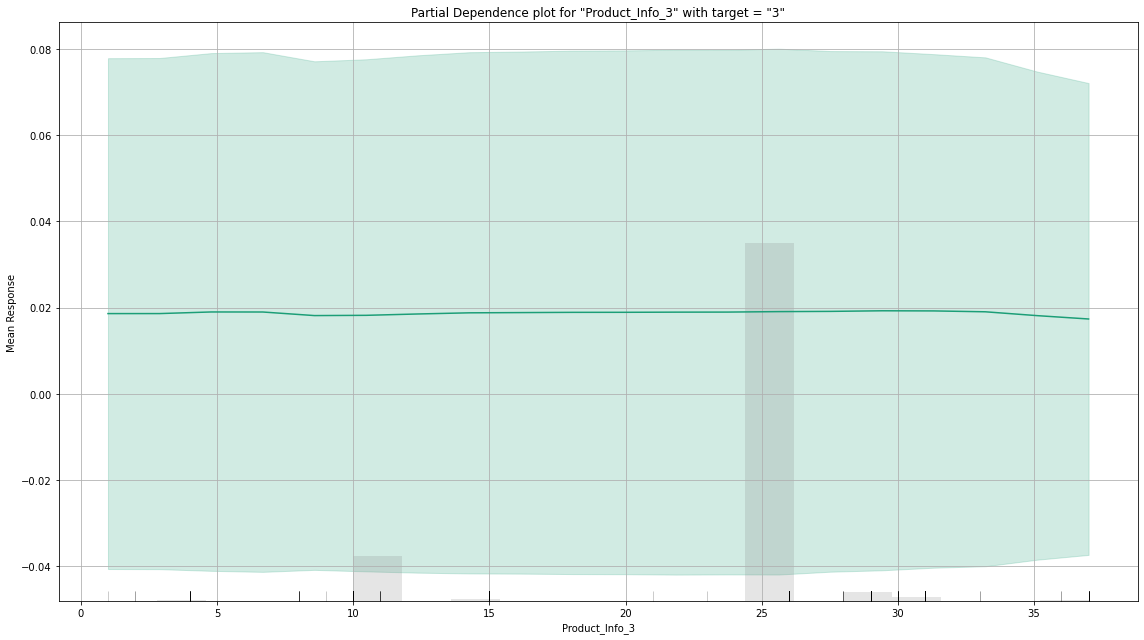

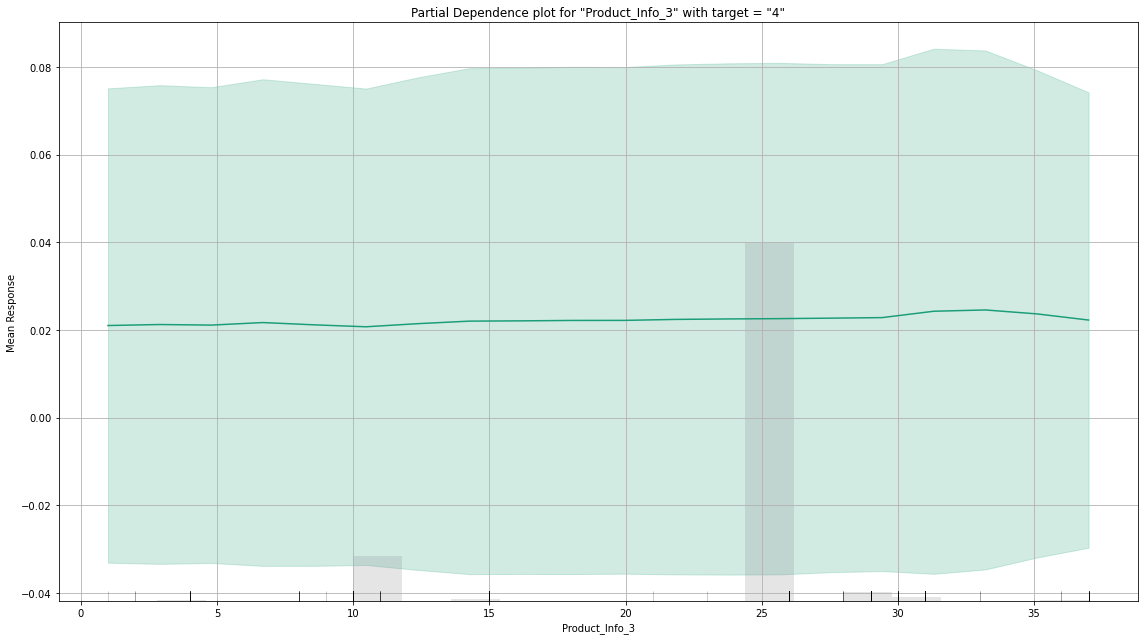

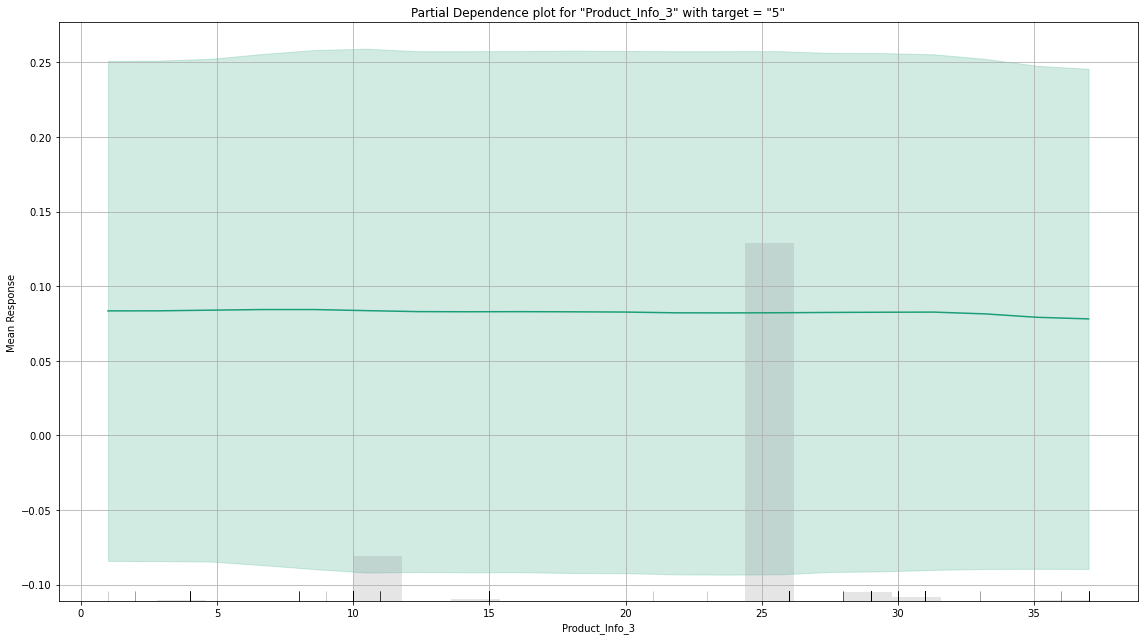

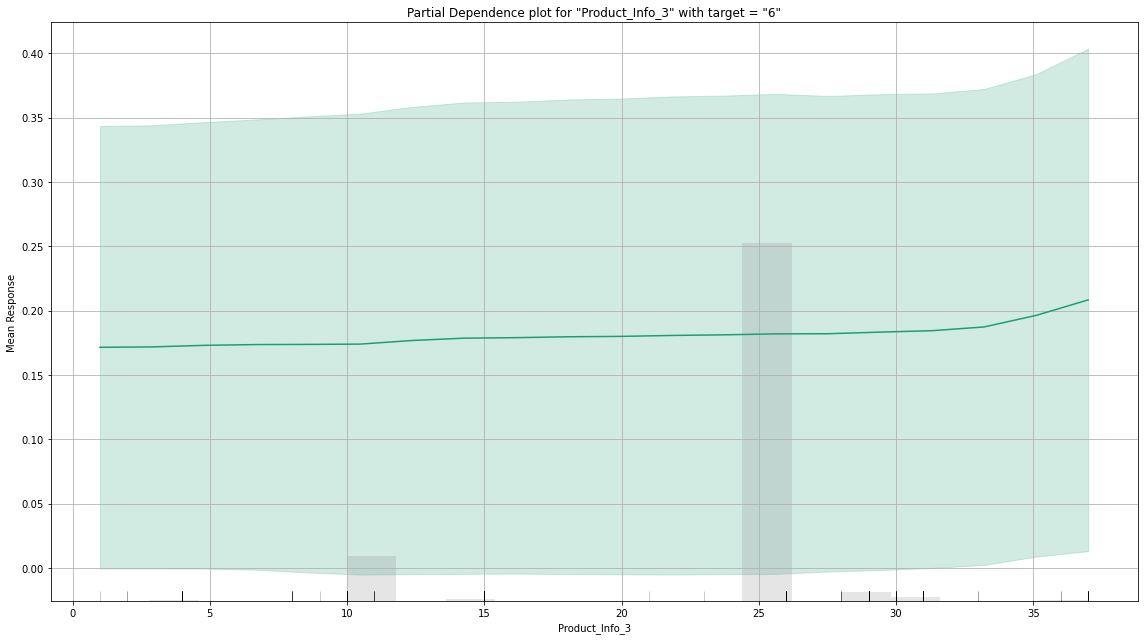

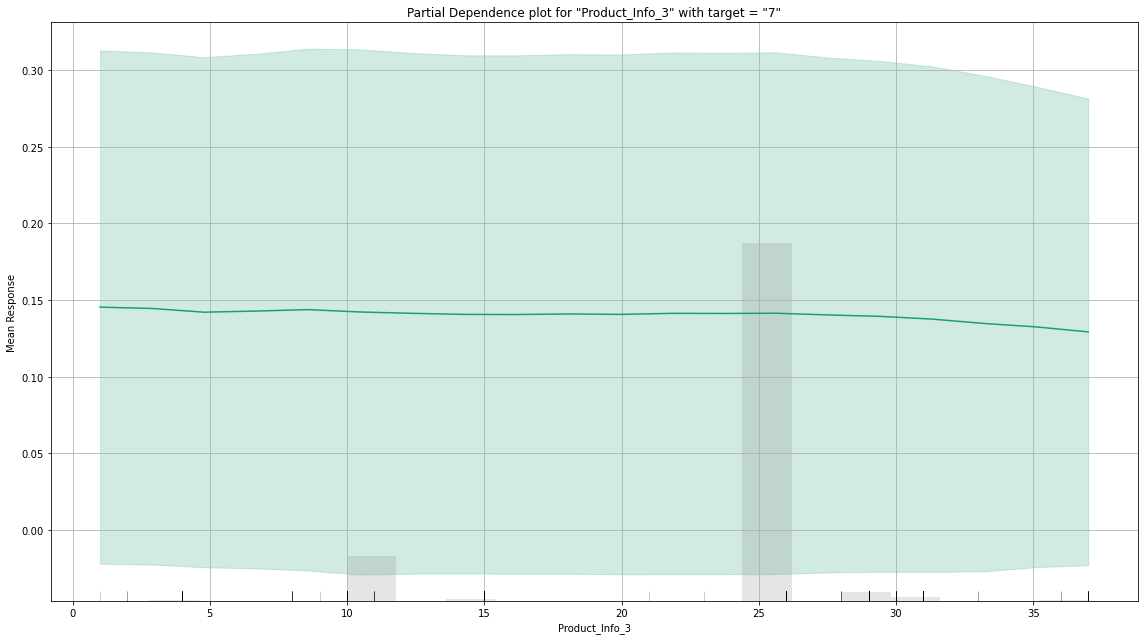

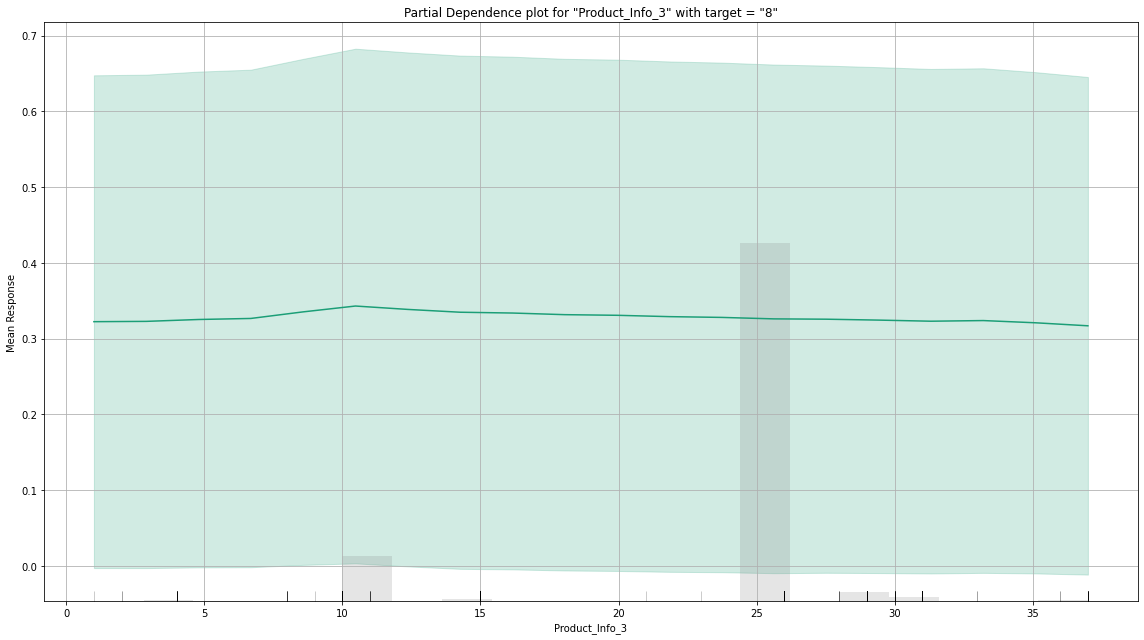

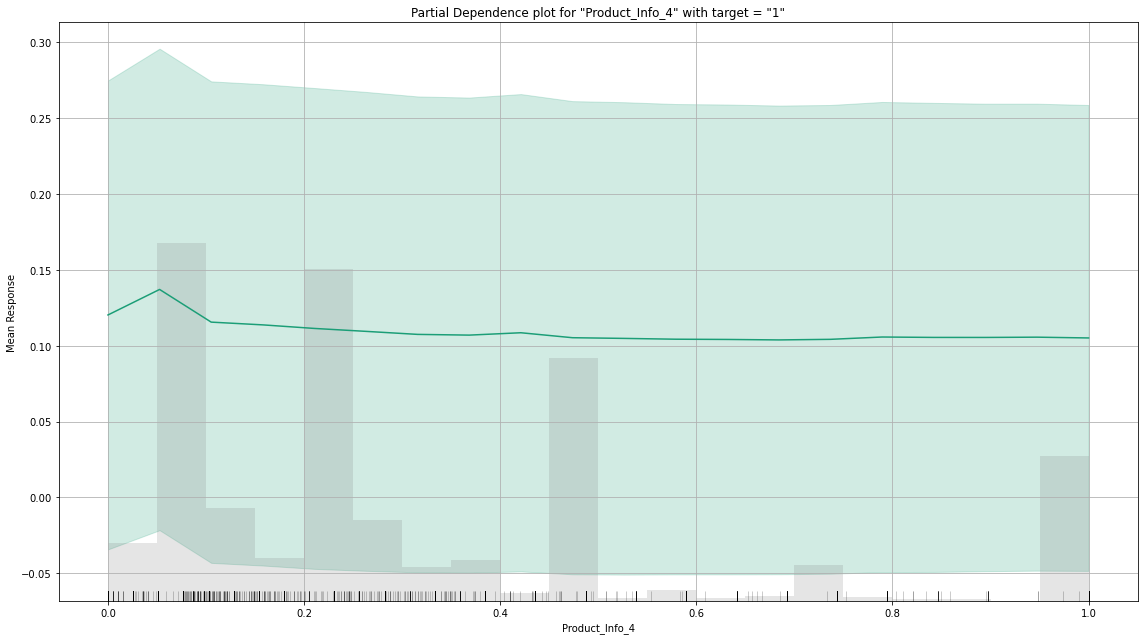

KeyboardInterrupt: 

<Figure size 1152x648 with 0 Axes>

In [18]:
# Setup validation set (15%) for model explainability
_, _, val_frame = main_frame.split_frame(ratios=[.7, .15])

# Explain a single H2O model (NOTE: This takes a long time to run)
exm = best_model.explain(val_frame)

#### Individual Conditional Expectation (ICE) Plot
- Visualizes the interaction (or dependence) between the predicted target response and a set of input features of interest

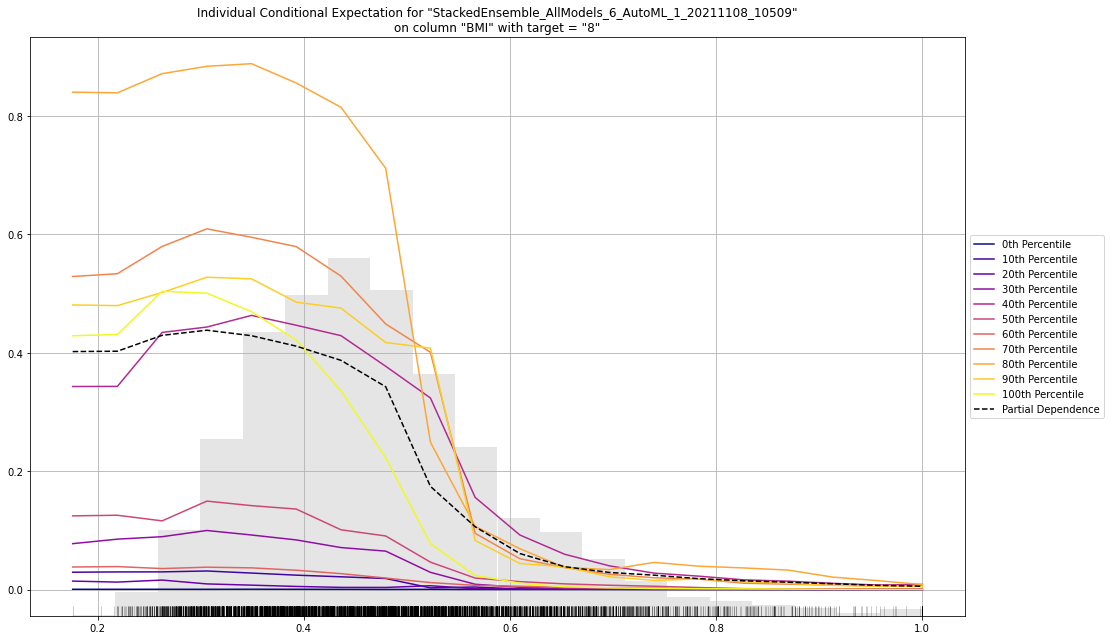

In [19]:
# Displaying sample ICE plot
ice_plot = best_model.ice_plot(val_frame, target='8', column='BMI')

___
<a name="references"></a>
## (5) References

- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/automl.html
- https://www.mlflow.org/docs/latest/python_api/mlflow.h2o.html
- https://h2o-release.s3.amazonaws.com/h2o/master/3888/docs-website/h2o-docs/save-and-load-model.html
- https://github.com/BogdanCojocar/medium-articles/blob/master/mlflow-automl/mlflow_automl.ipynb
- https://setscholars.net/automl-h2o-project-a-guide-to-build-a-multi-class-classification-model-in-python-using-car-description-data/
- https://stats.stackexchange.com/questions/276067/whats-considered-a-good-log-loss
- https://docs.h2o.ai/h2o/latest-stable/h2o-docs/explain.html#output-explanations
- https://github.com/mlflow/mlflow/blob/master/examples/h2o/random_forest.py
- Good overview on motivation behind MLflow: https://www.mlflow.org/docs/latest/concepts.html
___
References for FastAPI main.py
- https://www.mlflow.org/docs/latest/models.html#h2o-h2o
- https://github.com/zademn/mnist-mlops-learning/blob/master/backend/main.py
- https://moez-62905.medium.com/?p=333c710dc786
- https://fastapi.tiangolo.com/tutorial/request-files/
- https://medium.com/analytics-vidhya/fundamentals-of-mlops-part-4-tracking-with-mlflow-deployment-with-fastapi-61614115436
- https://stackoverflow.com/questions/62749365/send-a-csv-file-to-fastapi-and-get-a-new-file-back
- https://davidefiocco.github.io/streamlit-fastapi-ml-serving/